## evaluate_UNET_Selina - ROC-Curve


In this notebook we apply the previously trained model to a set of images and evaluate the quality of the prediction.

This includes the following steps:

* load the original dataset
* prerpocess the dataset (zero center, normalize to range -1 to 1)
* feed the data to the model
* find the ellipses in the predicted likelihood image
* match pairs of predicted and original ellipses
* calculate quality measures
* calculate tpr and fpr for different thresholds

### ROC-Curve
receiver operating characteristic curve means plotting the true positive rate (TPR) against the false positive rate (FPR) for various thresholds.

TPR is also known as the sensitivity/recall of the model
$$ TPR = \frac{TP}{P}$$, where TP is the number of GT ellipses detected by the network and P the total number of GT ellipses.

FPR is the probability of false alarm

$$FPR = \frac{FP}{N} = \frac{FP}{FP + TN} = 1 - TNR$$

Since we do not know the total amount of negatives, we have to normalize the data as $FPR = \frac{FP}{max(FP)}$. This allows us to compare the data.

In [1]:
!ls /tf/results/models/

Unet_0-0-0.h5		       Unet_0-0-4_20200423-075700.h5
Unet_0-0-0_20200411-124102.h5  Unet_0-0-4_20200423-093523.h5
Unet_0-0-1.h5		       Unet_0-0-5_fl_RAda,_20200507-094138.h5
Unet_0-0-1_20200411-120615.h5  Unet_0-0-5_fl_RAdam_20200426-134706.h5
Unet_0-0-1_20200411-122810.h5  Unet_0-0-5_fl_RAdam_20200512-094113.h5
Unet_0-0-1_20200411-132132.h5  Unet_0-0-5_fl_RAdam_20200522-122844.h5
Unet_0-0-1_20200413-105017.h5  Unet_0-0-5_fl_RAdam_20200525-084831.h5
Unet_0-0-2_20200413-190741.h5  Unet_0-0-5_fl_RAdam_20200602-100339.h5
Unet_0-0-3_20200414-144612.h5  Unet_0-0-5_fl_RAdam_20200602-115253.h5
Unet_0-0-4_20200423-064224.h5  Unet_0-0-5_fl_RAdam_20200603-153056.h5
Unet_0-0-4_20200423-070809.h5  Unet_0-0-5_fl_RAdam_20200610-140630.h5
Unet_0-0-4_20200423-070930.h5  Unet_0-0-5_fl_RAdam_20200610-141144.h5
Unet_0-0-4_20200423-071031.h5  Unet_0-0-5_fl_RAdam_20200615-152004.h5
Unet_0-0-4_20200423-071209.h5  Unet_0-0-5_fl_RAdam_20200615-191423.h5
Unet_0-0-4_20200423-071259.h5  Unet_0-0-5_fl_RAdam_20200

In [2]:
import tensorflow as tf
# TODO: remove after tf2.0 migration
# handle tf API changes 1.x to 2.0
from packaging import version
if version.parse(tf.__version__) < version.parse('2.0'):
    opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=opts))
else:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
## check if tf detected a GPU 
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x for x in local_device_protos if x.device_type == 'GPU']



print("GPU device id: ", tf.test.gpu_device_name())
print("GPU details: \n" , get_available_gpus())

1 Physical GPUs, 1 Logical GPUs
GPU device id:  /device:GPU:0
GPU details: 
 [name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7635468288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9565361580353533470
physical_device_desc: "device: 0, name: Quadro M4000, pci bus id: 0000:65:00.0, compute capability: 5.2"
]


In [3]:
## load the UNet model from UNETmodel.py
# details the the network can be found here: 
from includes.UNETmodel import UNet

# create model takes two arguments, the dimension of the input image (width x height x channels)
# and the number of classes 
# TODO: check if the last activation function is correctly choosen in this implementation!
with tf.device('/cpu:0'):
    #unet = UNet().create_model((540,300,1),1, d=32)
    #unet.load_weights("/tf/results/models/Unet_0-0-1_20200413-105017.h5")
    
    unet = UNet().create_model((720,540,1), 1 , d=8)
    unet.load_weights("/tf/results/models/Unet_0-0-5_fl_RAdam_20200610-141144.h5")

network = 'Cell_contours_training_data_'

build UNet ...


In [4]:
#### Copied Training setup
from datetime import datetime

test_size = 0.2
random_state = 121
epochs = 100
batch_size = 4
learning_rate = 1e-5
loss = 'binary_crossentropy'
metrics = ['accuracy']
stats = dict(
    name="Unet",
    version="0-0-1",
    date=datetime.now().strftime('%Y%m%d-%H%M%S'),
    data_raw="-".join(["M1p1","M1p2","M1p3"]),
    data_split="%d-%d"%(test_size*100, random_state),
    model_path="/tf/results/results/models/",
    model_ext="h5",
    log_path="/tf/results/results/logs/",
    img_path="/tf/results/results/singlePredictions/"
)

## Convert mask to ellipse
There are 2 steps to perform. The first is the conversion from a binary mask to individual object edges. We achieve this by the scikit-image methods **label**, which enumerates the individual patches of objects within the mask. Then we use **binary_erosion**, which removes the outer edge of all patches within one mask and XOR the result with the original mask. This yields the edge of the object mask.<br>
In the second step we apply the opencv routine **fitEllipse** to the pixel positions of the mask edge pixels. It is based on a algebraic distance minimisation process described in [Fitzgibbon95].
<br><br>
Fitzgibbon95: Andrew W. Fitzgibbon, R.B.Fisher. A Buyer’s Guide to Conic Fitting. Proc.5th British Machine Vision Conference, Birmingham, pp. 513-522, 1995. The technique used for ellipse fitting is the first one described in this summary paper.

In [5]:
from skimage.measure import label
from skimage.measure import regionprops
from skimage.morphology import binary_erosion
import cv2
import os
import imageio
import numpy as np

def fit_ellipses_regionprops(p):
    labeled = label(p)
    out = []
    for region in regionprops(labeled,p):  
        if region.area >= 100: #analyze only regions larger than 100 pixels
        #if region.area >= Amin_pixels:
            fit = ((region.centroid[0],region.centroid[1]),(region.minor_axis_length,region.major_axis_length),90 - np.rad2deg(-region.orientation))
            out.append(fit)
    return out

In [6]:
def preprocess(img):
    return (img - np.mean(img)) / np.std(img).astype(np.float32)

## Show results for individual image
We apply the network to the image with the number "id" in the clickpoints database.
We plot the original image, the predicted likelihood, the human expert mask and the prediction mask.<br>
We alpha overlay this with the fitted ellipses from the prediction mask image in red.

## Apply to all images
We apply the network to all images. Most of the code is handling of file paths and Database entries to get the prediction to the correct img. The actual ellipse prediction for raw image **img** is:
```python
prediction_mask =unet.predict(img[None,:,:,0,None].astype(np.float32)/255.).squeeze()>0.5
ellipses_n = np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses(prediction_mask)])
```
We match the predicted ellipses to the original ones, enabling us to calculate evaluation metrics. For this we use the euclidian distance between a **ground truth** (manual acquired) ellipse and a **system** (redicted by network + opencv) ellipse center as the cost of matching this pair. We match via the **linear_sum_assignment** function implemented in scipy, which builts up on the "hungarian algorithm" by Kuhn and Munkres [Kuhn55].<br>
We save the predicted and ground truth ellipses in one clickpoints database. The pairs of matched ellipses get the same text annotation with one image wise id. The unmatched ground truth ellipses get another id, the unmatched system ellipses get a "x".
<br><br>
H. W. Kuhn (1955): The Hungarian method for the assignment problem. Naval Research Logistics Quarterly 2, S. 83–97.

Calculate flatfield

In [7]:
import os
import clickpoints
import numpy as np
from scipy.optimize import linear_sum_assignment
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

from skimage.draw import ellipse       # generate binary mask
from matplotlib.path import Path


search_path = '../results/cell_contours/train'
file_list = []
for root, dirs, files in os.walk(search_path):
    for file in files:
        if not file.endswith(".cdb"):
            continue
        file_list.append(os.path.abspath(os.path.join(root, file)))
# all cdb files with images and ellipses

len_tot = 0

Trues = []
TP = []
FN = []
FP = []
precision = []
TPR = []
F1 = []
num_cells = 0

nx, ny = 540,720
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()
points = np.vstack((x,y)).T

#Thresholds = np.arange(0.1,1,0.1)
#Thresholds = list(np.arange(0.01,0.1,0.01)) + list(np.arange(0.1,1,0.1)) + list(np.arange(0.91,1,0.01))
Thresholds = list(np.arange(0.1,1,0.1)) + list(np.arange(0.91,1,0.01))

Thresholds = np.array(Thresholds)

area_too_small = []
overlap = []
num_overlap = []

for threshold in Thresholds:
    print('New threshold: {}'.format(threshold))
    GT = []  # Manually acquired ellipses
    GTMatchR = []
    SysMatchR = []  # System ellipses (regionprops) with matching ellipses
    SysR = []  # By system acquired (regionprops)
    
    for cdb_file in file_list:
        cdb = clickpoints.DataFile(cdb_file)
        
        q_poly = cdb.getPolygons()
        print("#%d found" % q_poly.count())

        # get the image ids which contain at least on polygon # in ground truth
        img_ids = np.unique([el.image.id for el in q_poly])
        #print(img_ids)
        
        # How many images in cdb
        q_img = cdb.getImages()
        ids = np.unique([i.id for i in q_img])
        print("#%d images" % len(ids))
        #print(len(ids))
        len_tot += len(ids)
        area = 0
        
        for id in ids:
            # get image object by id and image data
            img_o = cdb.getImage(id=id)
            img   = img_o.get_data()
            if len(img.shape) == 3:
                img = img[:,:,0]
            with tf.device('/cpu:0'):
                im = preprocess(img[None,:,:,None])
                prediction_mask = unet.predict(im).squeeze() > threshold
                ellipses_r = np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses_regionprops(prediction_mask)])

            SysR.extend(ellipses_r)
            # get ellipses in this image 
            
            if id in img_ids:
                nx, ny = 540,720
                x, y = np.meshgrid(np.arange(nx), np.arange(ny))
                x, y = x.flatten(), y.flatten()
                points = np.vstack((x,y)).T

                mask = np.zeros((img.shape[0:2]), dtype=np.uint8)
                q_polys=cdb.getPolygons(image=img_o)
                for pol in q_polys:
                    if np.shape(pol)[0] != 0:
                        num_cells += 1
                        polygon = np.array([pol.points])
                        path = Path(polygon.squeeze())
                        grid = path.contains_points(points)
                        grid = grid.reshape((ny,nx))
                        mask += grid

                ellipses_o = np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses_regionprops(mask)])
                GT.extend(ellipses_o)

                ### Try matching with GT ###
                #print('GT and prediction comparison')           
                if np.shape(ellipses_r)[0] != 0 and np.shape(ellipses_o)[0] != 0:    
                    costR = np.linalg.norm(ellipses_o[None,:,:2]-ellipses_r[:,None,:2], axis=-1)
                    sys_ids_r, gt_ids_r = linear_sum_assignment(costR)     

                    #print(sys_ids_r)
                    # costR has to be under a certain value. Centers have to be at closer than 50 pixels apart
                    index = []
                    for i in range(len(sys_ids_r)):
                        if costR[sys_ids_r[i],gt_ids_r[i]] > 50:
                            #print('Here R')
                            #print(sys_ids_r,gt_ids_r, costR)
                            index.append(i)
                            
                    sys_ids_r = np.delete(sys_ids_r,index)
                    gt_ids_r = np.delete(gt_ids_r,index)
                    #print(sys_ids_r)
                    #print(sys_ids_r,gt_ids_r)
                    len_before = len(sys_ids_r)
                    # We just accept ellipses that have a min area overlap of 0.7 area of GT ellipse
                    index = []
                    for i in range(len(sys_ids_r)):
                        el=ellipses_o[gt_ids_r[i]]
                        mask_o = np.zeros((np.shape(img)[0:2]), dtype=np.uint8)
                        ys,xs = ellipse(el[0], el[1],  el[2]/2, el[3]/2, rotation=np.deg2rad(el[4]))
                        for n in range(len(xs)):
                            if xs[n]<720 and ys[n] < 540:
                                mask_o[xs[n],ys[n]] = 1
                        el=ellipses_r[sys_ids_r[i]]
                        mask_r = np.zeros((np.shape(img)[0:2]), dtype=np.uint8)
                        ysr,xsr = ellipse(el[0], el[1],  el[2]/2, el[3]/2, rotation=np.deg2rad(el[4]))
                        for n in range(len(xsr)):
                            if xsr[n]<720 and ysr[n] < 540:
                                mask_r[xsr[n],ysr[n]] = 1
                        overlap.append(np.sum(mask_o * mask_r) / np.sum(mask_o))

                        if np.sum(mask_o * mask_r) < 0.7 * np.sum(mask_o):
                            index.append(i)
                            area += 1
                    sys_ids_r = np.delete(sys_ids_r,index)
                    gt_ids_r = np.delete(gt_ids_r,index)
                    len_after = len(sys_ids_r)

                    GTMatchR.extend(ellipses_o[gt_ids_r])
                    SysMatchR.extend(ellipses_r[sys_ids_r])
    
    area_too_small.append(area)
    print(area_too_small)
    
    plt.plot(overlap,'o')
    num_overlap.append(len(overlap))
    
    GT=np.array(GT)

    # Matched ellipses with regionprops
    GTMatchR=np.array(GTMatchR)
    SysR=np.array(SysR)
    SysMatchR=np.array(SysMatchR)

    print('Threshold: {}'.format(threshold))

    print(np.shape(GT))

    print('GT and SysR')
    print(np.shape(GTMatchR))
    print(np.shape(SysR))
    print(np.shape(SysMatchR))

    Trues.append(np.shape(GT)[0])
    print('total true: {}'.format(Trues[-1]))

    TP.append(np.shape(SysMatchR)[0])
    FN.append(np.shape(GT)[0] - np.shape(SysMatchR)[0])
    FP.append(np.shape(SysR)[0] - np.shape(SysMatchR)[0])

    print('TP = {} ,FN = {} ,FP = {}'.format(TP[-1],FN[-1],FP[-1]))
    precision.append(TP[-1] / (TP[-1] + FP[-1]))
    TPR.append(TP[-1] / (TP[-1] + FN[-1]))
    try:
        F1.append((2 * precision[-1] * TPR[-1]) / (precision[-1] + TPR[-1]))
    except:
        F1.append(0)
    print('Neural Network + Regionprops: \n precision = %.4f, recall = %.4f, F1-score = %.4f' % (precision[-1], TPR[-1], F1[-1]))

print('Done!')

no openslide found
New threshold: 0.1
path /tf/results/cell_contours/train/gt_8_selina.cdb
Open database with version 22
#241 found
#500 images
path /tf/results/cell_contours/train/gt_7_selina.cdb
Open database with version 22
#310 found
#500 images
path /tf/results/cell_contours/train/gt_4_selina.cdb
Open database with version 22
#302 found
#500 images
path /tf/results/cell_contours/train/gt_5_richard.cdb
Open database with version 22
#411 found
#500 images
path /tf/results/cell_contours/train/gt_0_selina.cdb
Open database with version 22
#484 found
#500 images
path /tf/results/cell_contours/train/gt_3_selina.cdb
Open database with version 22
#416 found
#500 images
path /tf/results/cell_contours/train/gt_6_selina.cdb
Open database with version 22
#293 found
#500 images
[0]
Threshold: 0.1
(2440, 5)
GT and SysR
(2392, 5)
(9687, 5)
(2392, 5)
total true: 2440
TP = 2392 ,FN = 48 ,FP = 7295
Neural Network + Regionprops: 
 precision = 0.2469, recall = 0.9803, F1-score = 0.3945
New threshold:

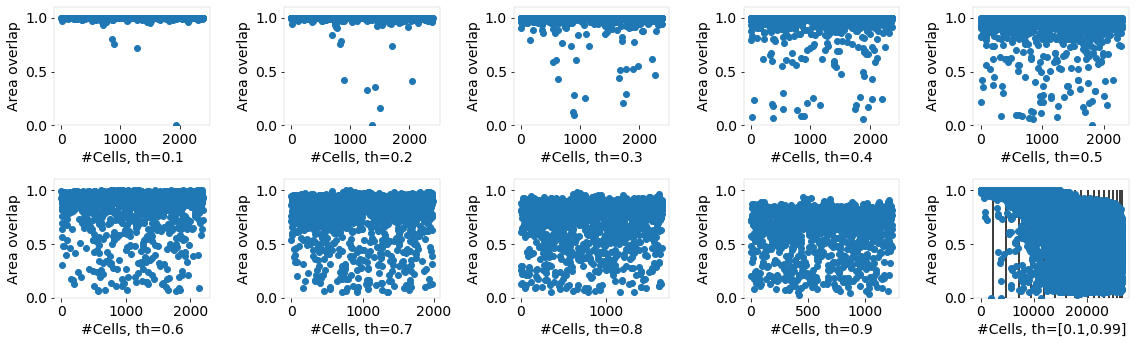

In [23]:
network='Cell_contours_small_thresholds_new_train_'
dev_1 = overlap[:num_overlap[0]]
dev_2 = overlap[num_overlap[0] + 1:num_overlap[1]]
dev_3 = overlap[num_overlap[1] + 1:num_overlap[2]]
dev_4 = overlap[num_overlap[2] + 1:num_overlap[3]]
dev_5 = overlap[num_overlap[3] + 1:num_overlap[4]]
dev_6 = overlap[num_overlap[4] + 1:num_overlap[5]]
dev_7 = overlap[num_overlap[5] + 1:num_overlap[6]]
dev_8 = overlap[num_overlap[6] + 1:num_overlap[7]]
dev_9 = overlap[num_overlap[7] + 1:num_overlap[8]]

font = {'family' : 'sans-serif',
        'sans-serif':['Arial'],
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('legend', fontsize=12)
plt.rc('axes', titlesize=18)    
plt.rcParams['axes.linewidth'] = 0.1 #set the value globally

#dev_1 = overlap[num_overlap[9] + 1:num_overlap[10]]
#dev_2 = overlap[num_overlap[10] + 1:num_overlap[11]]
#dev_3 = overlap[num_overlap[11] + 1:num_overlap[12]]
#dev_4 = overlap[num_overlap[12] + 1:num_overlap[13]]
#dev_5 = overlap[num_overlap[13] + 1:num_overlap[14]]
#dev_6 = overlap[num_overlap[14] + 1:num_overlap[15]]
#dev_7 = overlap[num_overlap[15] + 1:num_overlap[16]]
#dev_8 = overlap[num_overlap[16] + 1:num_overlap[17]]
#dev_9 = overlap[num_overlap[17] + 1:num_overlap[18]]

fig, axes = plt.subplots(2,5,figsize=[16,5],)
axes=np.array(axes)

ax = axes[0,0]
ax.plot(dev_1,'o')
ax.set_xlabel("#Cells, th=0.1")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)

ax = axes[0,1]
ax.plot(dev_2,'o')
ax.set_xlabel("#Cells, th=0.2")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)

ax = axes[0,2]
ax.plot(dev_3,'o')
ax.set_xlabel("#Cells, th=0.3")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)

ax = axes[0,3]
ax.plot(dev_4,'o')
ax.set_xlabel("#Cells, th=0.4")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)

ax = axes[0,4]
ax.plot(dev_5,'o')
ax.set_xlabel("#Cells, th=0.5")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)

ax = axes[1,0]
ax.plot(dev_6,'o')
ax.set_xlabel("#Cells, th=0.6")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)

ax = axes[1,1]
ax.plot(dev_7,'o')
ax.set_xlabel("#Cells, th=0.7")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)

ax = axes[1,2]
ax.plot(dev_8,'o')
ax.set_xlabel("#Cells, th=0.8")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)

ax = axes[1,3]
ax.plot(dev_9,'o')
ax.set_xlabel("#Cells, th=0.9")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)

from matplotlib.pyplot import vlines
ax = axes[1,4]
ax.plot(overlap,'o')
ax.set_xlabel("#Cells, th=[0.1,0.99]")
ax.set_ylabel('Area overlap')
ax.set_ylim(0,1.1)
ax.vlines(num_overlap,0,1)

fig.tight_layout()
plt.savefig('/tf/results/results_new/ROC/' + network + 'area_overlaps' + '.png')

[0.         0.         0.00046653 0.00055757 0.0012837  0.00576369
 0.01390645 0.02897051 0.05602837 0.05930319 0.06724003 0.07475083
 0.08333333 0.09001957 0.09141583 0.1064389  0.11669368 0.13399504]


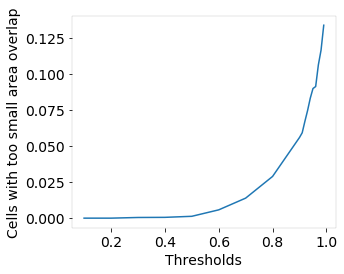

In [24]:
Trues = np.array(Trues)
FP = np.array(FP)
TP = np.array(TP)

print(area_too_small/(FP + TP))
fig, ax = plt.subplots(figsize=[5,4])

plt.plot(Thresholds,area_too_small/(FP + TP))
plt.xlabel('Thresholds')
plt.ylabel('Cells with too small area overlap')
fig.tight_layout()
plt.savefig('/tf/results/results_new/ROC/' + network + 'area_too_small' + '.png')

## Plot ROC-Curve

plot of TPR vs FPR for different thresholds

In [25]:
network='new_train'

[0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.91 0.92 0.93 0.94 0.95
 0.96 0.97 0.98 0.99]
[0.980327868852459, 0.9807377049180328, 0.9733606557377049, 0.9508196721311475, 0.9008196721311476, 0.8147540983606557, 0.680327868852459, 0.48975409836065575, 0.255327868852459, 0.22377049180327868, 0.1987704918032787, 0.1737704918032787, 0.14057377049180328, 0.11024590163934427, 0.08524590163934426, 0.05573770491803279, 0.03360655737704918, 0.00819672131147541]
[7295 3536 1912 1267  918  788  713  738  787  803  794  780  785  753
  689  625  535  383]
[2392 2393 2375 2320 2198 1988 1660 1195  623  546  485  424  343  269
  208  136   82   20]


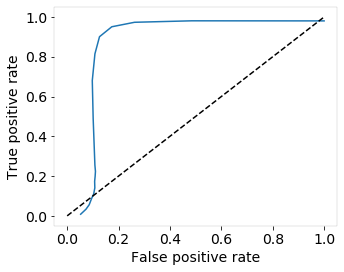

In [26]:
import matplotlib.pyplot as plt
print(Thresholds)
print(TPR)
print(FP)
print(TP)
fig, ax = plt.subplots(figsize=[5,4])
FPR = FP/(np.max(FP))
plt.plot(FPR,TPR)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
fig.tight_layout()
plt.savefig('/tf/results/results_new/ROC/ROC_curve/ROC_' + network + '.png')

In [27]:
from numpy import trapz
area = trapz(TPR, FPR)
print(-area)
print(np.max(TPR))
print(-area/np.max(TPR))

0.8735813042843178
0.9807377049180328
0.8907389813847619


Total area: 17456935.0
AUC: 15549572.5
AUC relative: 0.89074


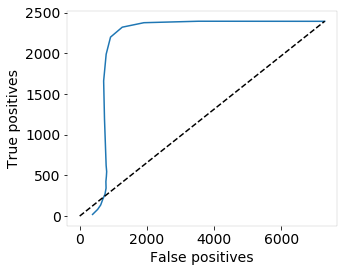

In [28]:
fig, ax = plt.subplots(figsize=[5,4])

plt.plot(FP,TP)
plt.plot([0,np.max(FP)],[0,np.max(TP)],'k--')

plt.xlabel('False positives')
plt.ylabel('True positives')
fig.tight_layout()
plt.savefig('/tf/results/results_new/ROC/ROC_curve/ROC_absolute_' + network + '.png')
area_total = (np.max(TP) * np.max(FP))
print('Total area: %.1f' % area_total)
area2 = -trapz(TP, FP)
print('AUC: %.1f' % area2)
print('AUC relative: %.5f' % (area2/area_total))

918 0.12583961617546263
2198 0.9008196721311476
0.7053915275994865
0.9008196721311476
0.791216702663787
0.5


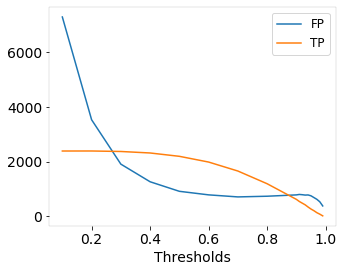

In [29]:
fig, ax = plt.subplots(figsize=[5,4])
plt.plot(Thresholds,FP)
plt.plot(Thresholds,TP)
plt.xlabel('Thresholds')
plt.legend(['FP','TP'],loc=1)
fig.tight_layout()
plt.savefig('/tf/results/results_new/ROC/ROC_curve/tp_fp_absolute_' + network + '.png')
print(FP[4], FPR[4])
print(TP[4], TPR[4])
print(precision[4])
print(TPR[4])
print(F1[4])
print(Thresholds[4])

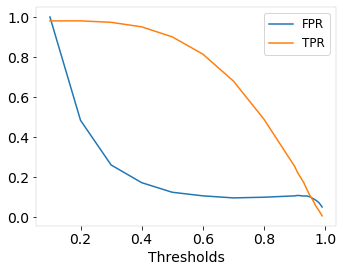

In [30]:
fig, ax = plt.subplots(figsize=[5,4])
plt.plot(Thresholds,FPR)
plt.plot(Thresholds,TPR)
plt.xlabel('Thresholds')
plt.legend(['FPR','TPR'],loc=1)
fig.tight_layout()
plt.savefig('/tf/results/results_new/ROC/ROC_curve/tpr_fpr_' + network + '.png')

0.526685057839515
0.25064201335387776


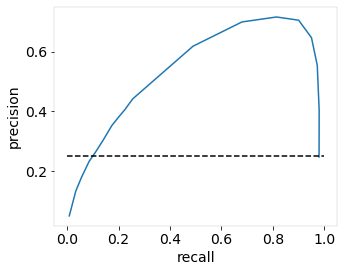

In [38]:
bad = Trues[0]/(np.max(FP)+Trues[0])

fig, ax = plt.subplots(figsize=[5,4])
plt.plot(TPR,precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.plot([bad,bad],'k--')
fig.tight_layout()
plt.savefig('/tf/results/results_new/ROC/ROC_curve/precision_recall_' + network + '.png')
area = trapz(precision,TPR)
print(-area)
print(bad)

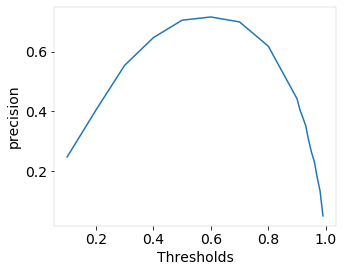

In [32]:
fig, ax = plt.subplots(figsize=[5,4])
plt.plot(Thresholds,precision)
plt.xlabel('Thresholds')
plt.ylabel('precision')
fig.tight_layout()
#plt.savefig('/tf/results/results_new/ROC/ROC_curve/precision_' + network + '.png')

Text(0, 0.5, 'recall')

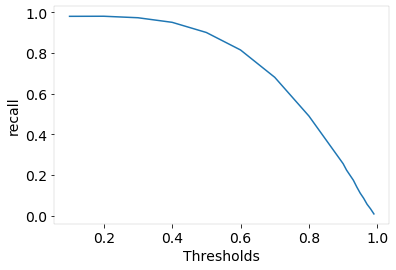

In [33]:
plt.plot(Thresholds,TPR)
plt.xlabel('Thresholds')
plt.ylabel('recall')
#plt.savefig('/tf/results/results_new/ROC/ROC_curve/recall_' + network + '.png')

[0.980327868852459, 0.9807377049180328, 0.9733606557377049, 0.9508196721311475, 0.9008196721311476, 0.8147540983606557, 0.680327868852459, 0.48975409836065575, 0.255327868852459, 0.22377049180327868, 0.1987704918032787, 0.1737704918032787, 0.14057377049180328, 0.11024590163934427, 0.08524590163934426, 0.05573770491803279, 0.03360655737704918, 0.00819672131147541]
[0.24692887374832248, 0.40360937763535165, 0.5540004665267086, 0.64678003902983, 0.7053915275994865, 0.7161383285302594, 0.6995364517488412, 0.6182100362131402, 0.4418439716312057, 0.4047442550037065, 0.37920250195465205, 0.3521594684385382, 0.30407801418439717, 0.26320939334637966, 0.2318840579710145, 0.17871222076215507, 0.13290113452188007, 0.04962779156327544]


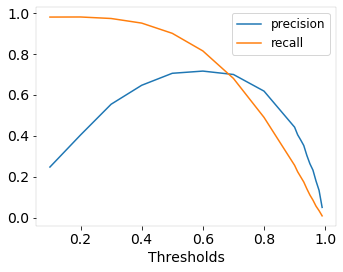

In [34]:
fig, ax = plt.subplots(figsize=[5,4])
plt.plot(Thresholds,precision)
plt.plot(Thresholds,TPR)
plt.xlabel('Thresholds')
plt.legend(['precision','recall'])
print(TPR)
print(precision)
fig.tight_layout()
plt.savefig('/tf/results/results_new/ROC/ROC_curve/p_vs_r_' + network + '.png')

Text(0, 0.5, 'FPR')

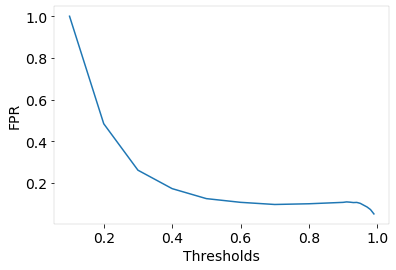

In [35]:
plt.plot(Thresholds,FPR)
plt.xlabel('Thresholds')
plt.ylabel('FPR')
#plt.savefig('/tf/results/results_new/ROC/ROC_curve/FPR_' + network + '.png')

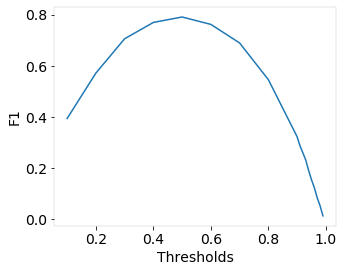

In [36]:
fig, ax = plt.subplots(figsize=[5,4])
plt.plot(Thresholds,F1)
plt.xlabel('Thresholds')
plt.ylabel('F1')
fig.tight_layout()
plt.savefig('/tf/results/results_new/ROC/ROC_curve/F1_' + network + '.png')

In [37]:
print(network)
print(precision[13])
print(TPR[13])
print(F1[13])
print()
print(network)
print(precision[4])
print(TPR[4])
print(F1[4])
Thresholds

new_train
0.26320939334637966
0.11024590163934427
0.15540150202195263

new_train
0.7053915275994865
0.9008196721311476
0.791216702663787


array([0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 0.91, 0.92,
       0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])